In [1]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [4]:
MERGEDTAGSCOMM = 'finalgamingtagcomment.parquet'


In [5]:
merged_commtags = pd.read_parquet(MERGEDTAGSCOMM)
merged_commtags.head()

,author,display_id,likes,replies,tags,upload_date
0,2,9pQILRT42Cg,0,0,"faze,fazeclan,banks,faze banks,my new girlfrie...",2017-06-22 00:00:00
1,2,PWWRzCyuiFU,0,0,,2018-06-03 00:00:00
2,5,9MuGpmXGlsY,0,0,"fortnite,fortnite gameplay,fortnite gotta chil...",2019-07-13 00:00:00
3,5,UvZPbfUkMGw,0,0,"fortnite,fortnite top 10,top 10 crazy ways peo...",2019-06-17 00:00:00
4,11,qj9sjQjQ19M,0,0,"مقلب ببجي,ببجي موبايل,pubg mobile,مقلب ببجي مو...",2019-02-22 00:00:00


In [6]:
colors = {'call of duty':'black','fifa': 'blue', 'pes': 'green', 'fortnite': 'red', 'league of legends': 'orange', 'minecraft': 'purple'}

frames = {tag: merged_commtags[merged_commtags['tags'].str.contains(tag, case=False)] for tag in tqdm(colors)}

print(frames)

100%|██████████| 6/6 [03:10<00:00, 31.78s/it]

{'call of duty':            author   display_id  likes  replies  \
41             16  P4soUB4N_7Y      0        0   
114            16  9BRuBptSTMk      0        0   
221            16  -D7KM5S4j94      0        0   
249            16  P4soUB4N_7Y      0        0   
259            16  _zLovAyL6YA      2        0   
...           ...          ...    ...      ...   
25658509  6695065  iO923YxI9OA      0        0   
25658639  6695100  GY4cFGgD7U0      0        0   
25658642  6695100  AinJbYHmnJo      0        0   
25658646  6695100  UOOVBatsYzY      1        0   
25658649  6695100  2mIlFC52bqc      0        0   

                                                       tags  \
41        Call of Duty Mobile,Call of Duty on Mobile,COD...   
114       apex legends gameplay,fortnite,battle royale,h...   
221       iferg,HawksNest,NoahFromYoutube,call of duty m...   
249       Call of Duty Mobile,Call of Duty on Mobile,COD...   
259       PUBG,playerunknowns,battlegrounds,battle royal...   
... 

In [26]:
for game in frames.keys():
    frames[game]['game'] = game

In [44]:
df = pd.concat(frames.values()).drop(columns=['tags', 'likes', 'replies']).sort_values(by='upload_date')

<Axes: xlabel='upload_date'>

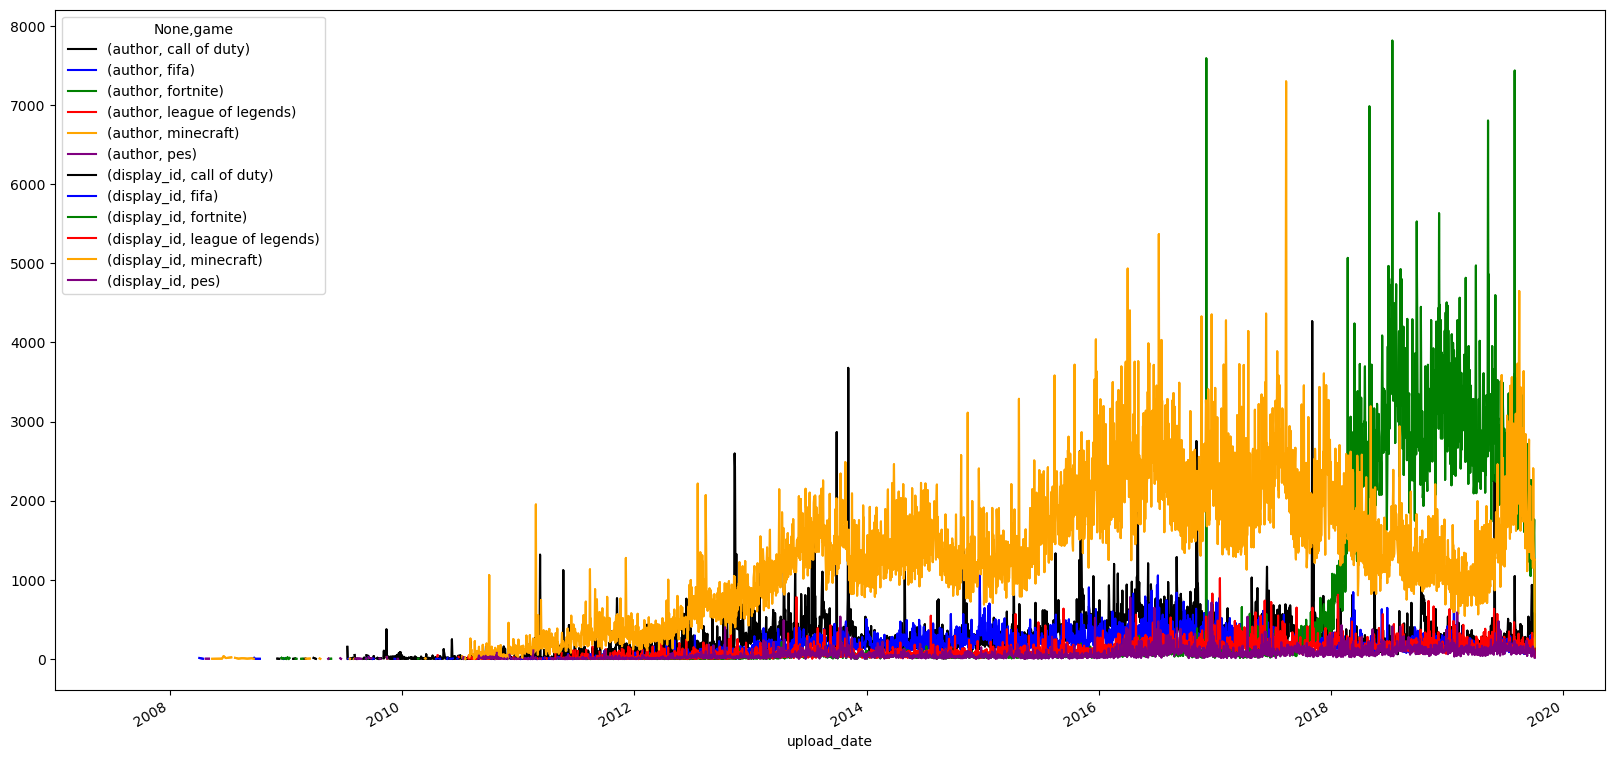

In [96]:
df['upload_date'] = pd.to_datetime(df['upload_date'])
df.groupby(['upload_date', 'game']).count().unstack().plot(figsize=(20,10), color=[colors[game] for game in frames.keys()])

In [86]:
uniqueauth = df['author'].unique()
author_dict = {author: None for author in uniqueauth}

upload_dates = df['upload_date'].unique()
dates_dict = {date: [] for date in upload_dates}

In [92]:
for index, row in tqdm(df.iterrows()):
    # Get the tags of the current author
    author_tags = row['game']
    
    # Iterate over each tag in tags
    for tag in frames.keys():
        # Check if the current tag is in the author_tags
        if tag in author_tags:
            # Perform your desired action here
            if author_dict[row['author']] == None:
                author_dict[row['author']] = tag
            else:
                dates_dict[row['upload_date']].append((author_dict[row['author']],tag))
                author_dict[row['author']] = tag


8497286it [01:58, 71549.49it/s]


In [93]:
from itertools import permutations
from collections import Counter
combs = list(permutations(list(frames.keys()), 2))

In [136]:
migrations = []
for date in tqdm(dates_dict.keys()):
    occs = Counter(dates_dict[date])
    for combination in combs:
        if combination not in occs.keys():
            occs[combination] = 0
    date_dict = {
        date: {
            'migrations': list(occs.items())
        }
    }
    migrations.append(date_dict)

100%|██████████| 3760/3760 [00:00<00:00, 13392.28it/s]


In [126]:
import networkx as nx


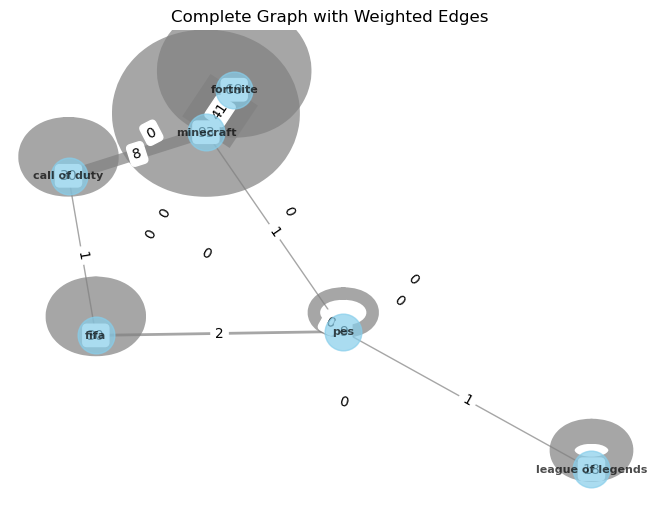

In [142]:
last_week_migrations = migrations[-1]
G = nx.Graph()

for data in last_week_migrations.values():
    migration_data = data['migrations']
    for migration in migration_data:
        origin = migration[0][0]
        destination = migration[0][1]
        count = migration[1]
        G.add_edge(origin, destination, weight=count)
        
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', width=[d['weight'] for (u, v, d) in G.edges(data=True)], alpha=0.7, edge_cmap=plt.cm.Blues)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title('Complete Graph with Weighted Edges')
plt.show()

In [119]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a complete graph with 6 nodes
G = nx.complete_graph(6)


# Rename the nodes
node_labels = {i: game for i, game in enumerate(frames.keys())}
G = nx.relabel_nodes(G, node_labels)

# Add weights to edges
edge_weights = {(0, 1): 2, (0, 2): 3, (0, 3): 1, (0, 4): 4, (0, 5): 5,
                (1, 2): 2, (1, 3): 3, (1, 4): 1, (1, 5): 4,
                (2, 3): 1, (2, 4): 5, (2, 5): 2,
                (3, 4): 4, (3, 5): 3,
                (4, 5): 1}

# Ensure 'weight' attribute is set for each edge
for edge, weight in edge_weights.items():
    G[edge[0]][edge[1]]['weight'] = weight

# Draw the graph with weighted edges using matplotlib
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', width=[d['weight'] for (u, v, d) in G.edges(data=True)], alpha=0.7, edge_cmap=plt.cm.Blues)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title('Complete Graph with Weighted Edges')
plt.show()

KeyError: 0

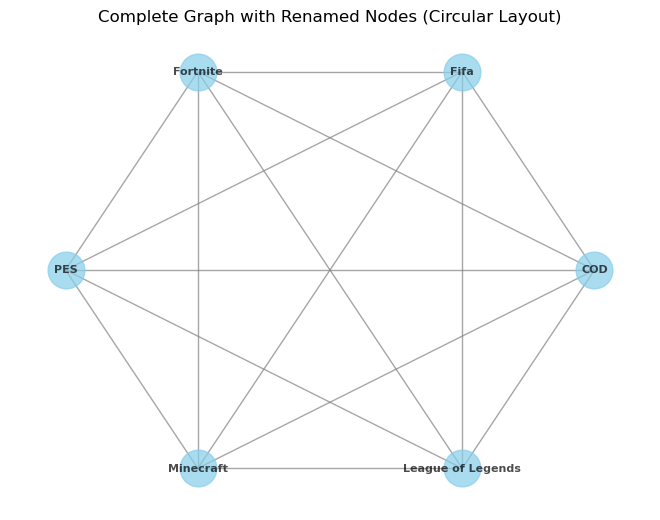

In [111]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a complete graph with 6 nodes
G = nx.complete_graph(6)

# Rename the nodes
node_labels = {0: 'COD', 1: 'Fifa', 2: 'Fortnite', 3: 'PES', 4: 'Minecraft', 5: 'League of Legends'}
G = nx.relabel_nodes(G, node_labels)

# Draw the graph using a circular layout
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=1, alpha=0.7)

# Show the plot
plt.title('Complete Graph with Renamed Nodes (Circular Layout)')
plt.show()
